In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa as lr
import librosa.display
from IPython.display import Audio
import warnings
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, LSTM
from keras.utils import to_categorical
%matplotlib inline

import os

Using TensorFlow backend.


In [2]:
warnings.filterwarnings("ignore")

In [3]:
SR = 5000
n_mfcc = 20

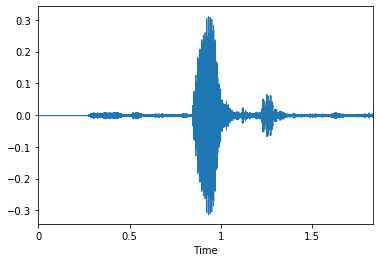

In [4]:
audio, sr = lr.load("./data/1/devi-khos-1a.wav", mono=True, sr=SR)
time = np.arange(0, len(audio)) / sr
plt.figure()
librosa.display.waveplot(audio, sr=sr)

In [5]:
Audio(audio, rate=SR)

In [6]:
def add_noise(data):
        noise = np.random.randn(len(data))
        data_noise = data + 0.005 * noise
        return data_noise

In [7]:
def shift(data):
        y_shift = data.copy()
        timeshift_fac = 0.2 *2*(np.random.uniform()-0.5)  # up to 20% of length
        
        start = int(y_shift.shape[0] * timeshift_fac)
        if (start > 0):
            y_shift = np.pad(y_shift,(start,0),mode='constant')[0:y_shift.shape[0]]
        else:
            y_shift = np.pad(y_shift,(0,-start),mode='constant')[0:y_shift.shape[0]]
        return y_shift

In [8]:
def stretch(data, rate=1):
        input_length = len(data)
        streching = data.copy()
        streching = librosa.effects.time_stretch(streching.astype('float'), 1.1)
        if len(streching) > input_length:
            streching = streching[:input_length]
        else:
            streching = np.pad(streching, (0, max(0, input_length - len(streching))), "constant")
        
        return streching

In [9]:
def pitch_and_speed(data):
    y_pitch_speed = data.copy()
    length_change = np.random.uniform(low=0.9, high = 1.1)
    speed_fac = 1.0  / length_change
    
    tmp = np.interp(np.arange(0,len(y_pitch_speed),speed_fac),np.arange(0,len(y_pitch_speed)),y_pitch_speed)
    minlen = min(y_pitch_speed.shape[0], tmp.shape[0])
    y_pitch_speed *= 0
    y_pitch_speed[0:minlen] = tmp[0:minlen]
    return y_pitch_speed

In [10]:
def pitch(data):
    y_pitch = data.copy()
    bins_per_octave = 12
    pitch_pm = 1.1
    pitch_change =  pitch_pm * 2 *(np.random.uniform())   
    y_pitch = librosa.effects.pitch_shift(y_pitch.astype('float64'), 
                                          sr, n_steps=pitch_change, 
                                          bins_per_octave=bins_per_octave)
    return y_pitch

In [11]:
def speed(data):
    y_speed = data.copy()
    speed_change = np.random.uniform(low=0.9,high=1.1)
    
    tmp = librosa.effects.time_stretch(y_speed.astype('float64'), speed_change)
    minlen = min(y_speed.shape[0], tmp.shape[0])
    y_speed *= 0 
    y_speed[0:minlen] = tmp[0:minlen]
    return y_speed

In [12]:
def augmentation(data):
    y_aug = data.copy()
    dyn_change = np.random.uniform(low=1.5,high=3)
    
    y_aug = y_aug * dyn_change
    return y_aug

In [13]:
def hpps(data):
    return librosa.effects.hpss(data.astype('float64'))[1]

In [14]:
def silent_to_the_right(data):
    sampling = data[(data > 0.001) | (data < -0.001)]
    shifted_silent = sampling.tolist() + np.zeros((data.shape[0] - sampling.shape[0])).tolist()
    return np.asarray(shifted_silent) 

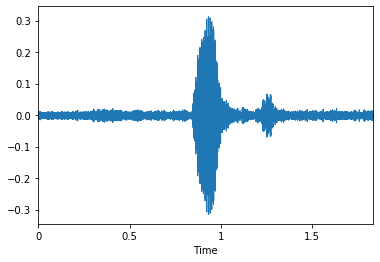

In [15]:
librosa.display.waveplot(add_noise(audio), sr=sr)

In [16]:
Audio(add_noise(audio), rate=sr)

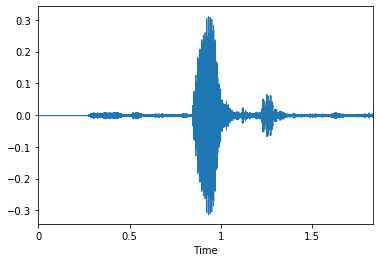

In [17]:
librosa.display.waveplot(shift(audio), sr=sr)

In [18]:
Audio(shift(audio), rate=sr)

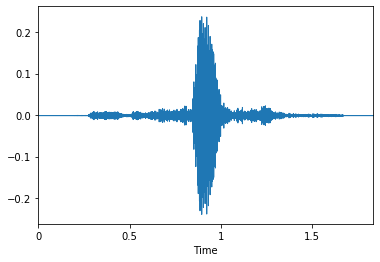

In [19]:
librosa.display.waveplot(stretch(audio), sr=sr)

In [20]:
Audio(stretch(audio), rate=sr)

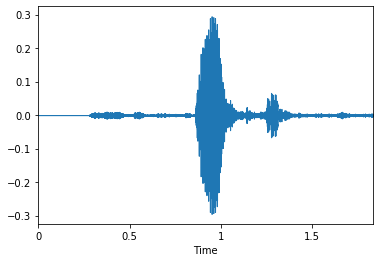

In [21]:
librosa.display.waveplot(pitch_and_speed(audio), sr=sr)

In [22]:
Audio(pitch_and_speed(audio), rate=sr)

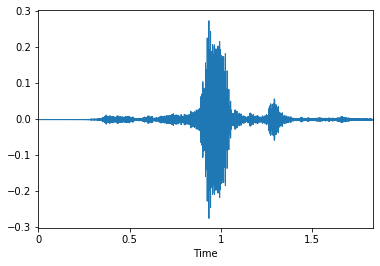

In [23]:
librosa.display.waveplot(pitch(audio), sr=sr)

In [24]:
Audio(pitch(audio), rate=sr)

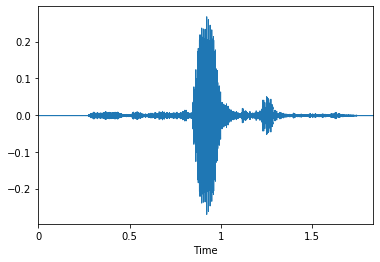

In [25]:
librosa.display.waveplot(speed(audio), sr=sr)

In [26]:
Audio(speed(audio), rate=sr)

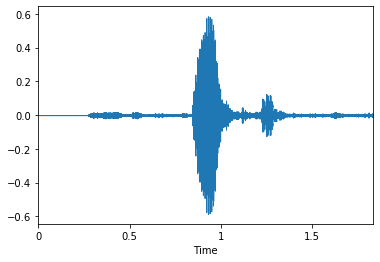

In [27]:
librosa.display.waveplot(augmentation(audio), sr=sr)

In [28]:
Audio(augmentation(audio), rate=sr)

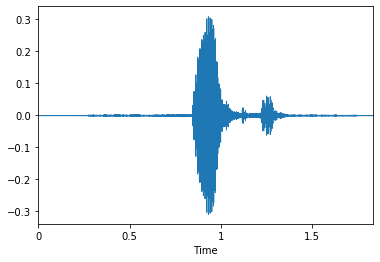

In [29]:
librosa.display.waveplot(hpps(audio), sr=sr)

In [30]:
Audio(hpps(audio), rate=sr)

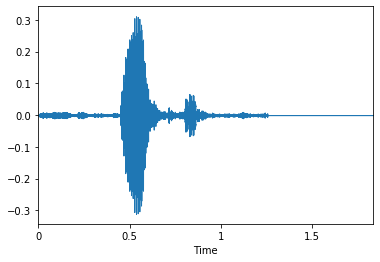

In [31]:
librosa.display.waveplot(silent_to_the_right(audio), sr=sr)

In [32]:
Audio(silent_to_the_right(audio), rate=sr)

In [33]:
def multiply_audio(audio):
    audios = []
    audios.append(audio)
    audios.append(add_noise(audio))
    
    audios.append(stretch(audio))
    audios.append(add_noise(stretch(audio)))
    
    audios.append(pitch_and_speed(audio))
    audios.append(add_noise(pitch_and_speed(audio)))
    
    audios.append(pitch(audio))
#     audios.append(add_noise(pitch(audio)))
    
    audios.append(speed(audio))
    audios.append(add_noise(speed(audio)))
    
    audios.append(augmentation(audio))
    audios.append(add_noise(augmentation(audio)))
    
    audios.append(hpps(audio))
    audios.append(add_noise(hpps(audio)))
    
    audios.append(silent_to_the_right(audio))
    audios.append(add_noise(silent_to_the_right(audio)))
    return audios

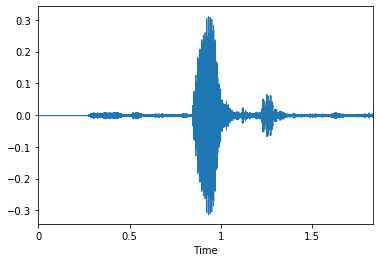

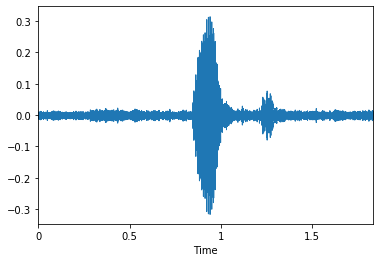

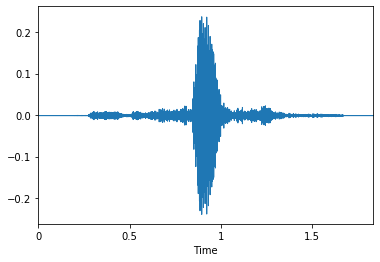

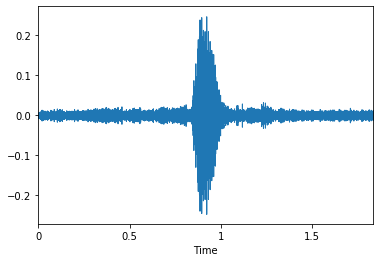

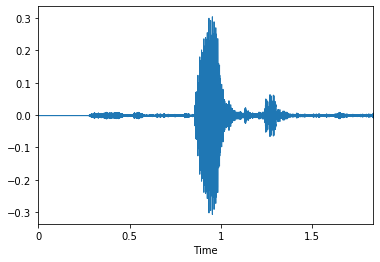

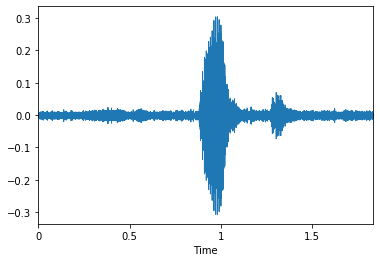

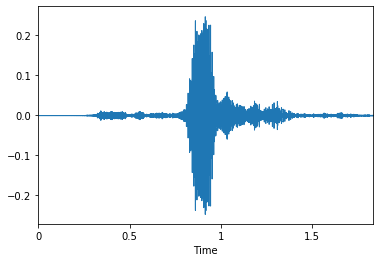

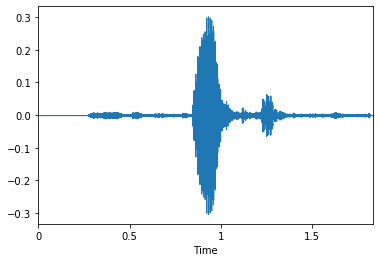

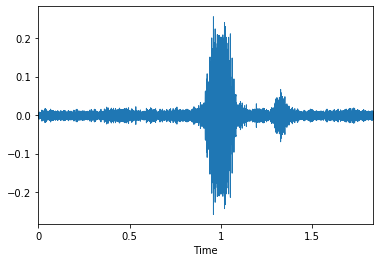

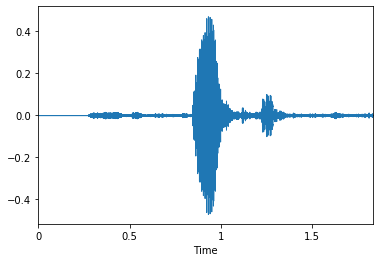

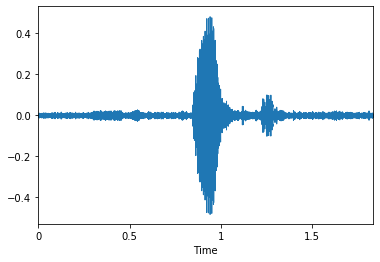

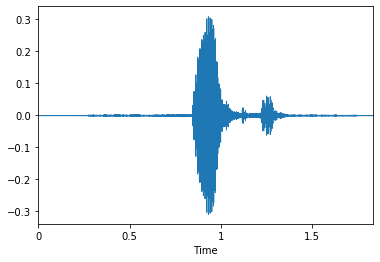

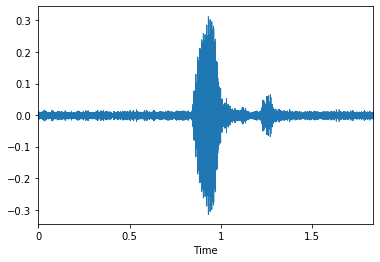

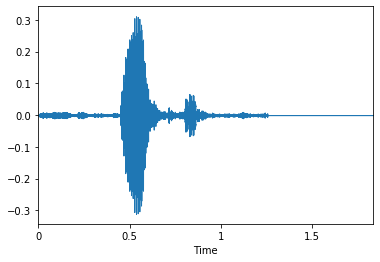

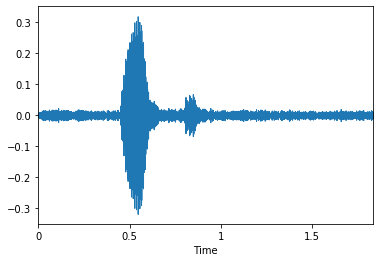

In [34]:
for curr_audio in multiply_audio(audio):
    plt.figure()
    librosa.display.waveplot(curr_audio, sr=sr)

In [35]:
def load_data(path, test_data=False):
    labels, voices = [], []
    for dirpath, dirnames, filenames in os.walk(path):
        try:
            label = int(dirpath.split("/")[-1])
        except:
            pass

        for filename in filenames:
            audio, sr = lr.load(os.path.join(dirpath, filename), mono=True, sr=SR)
            augmented_voices = multiply_audio(audio) if not test_data else [audio]
            labels += [label] * len(augmented_voices)
            voices += augmented_voices
    return voices, labels

In [36]:
voices, labels = load_data("./data")

(array([ 345.,  690., 1770., 3375., 1905., 1395.,  555.,  240.,   30.,
          15.]),
 array([ 2083. ,  3729.4,  5375.8,  7022.2,  8668.6, 10315. , 11961.4,
        13607.8, 15254.2, 16900.6, 18547. ]),
 <a list of 10 Patch objects>)

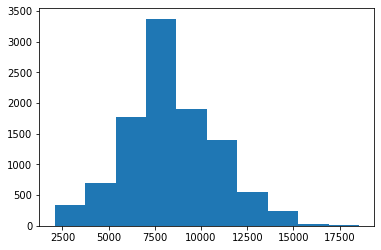

In [37]:
lengths = list(map(len, voices))
lengths.sort()
plt.hist(lengths)

In [42]:
def pad_voices(voices):
    max_length = max(map(len, voices))
    padded_voices = voices.copy()
    assert max(list(map(len, padded_voices))) != min(list(map(len, padded_voices)))
    return list(map(lambda v: np.pad(v, (0, max_length - len(v)), mode="constant"), padded_voices))

In [43]:
padded_voices = pad_voices(voices)

In [44]:
def get_mfccs(voices):
    return [librosa.feature.mfcc(voice, sr=SR, n_mfcc=n_mfcc) for voice in voices]

In [45]:
mfccs = get_mfccs(padded_voices)

In [ ]:
# mean_mfccs = [m.mean(axis=0) for m in mfccs]

In [ ]:
# plt.plot(mean_mfccs[220])

In [46]:
max_len = mfccs[0].shape[1]
max_len

37

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(mfccs, labels, train_size=0.8)

In [48]:
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
y_test = np.asarray([x[1:] for x in to_categorical(y_test)])
y_train = np.asarray([x[1:] for x in to_categorical(y_train)])

X_train = X_train.reshape(X_train.shape[0], n_mfcc, max_len, 1)
X_test = X_test.reshape(X_test.shape[0], n_mfcc, max_len, 1)

In [49]:
epochs = 20

In [ ]:
# model = Sequential()
# model.add(Flatten(input_shape=(n_mfcc, max_len, 1)))

# model.add(Dense(5, activation='softmax'))
# model.compile(loss="categorical_crossentropy",
#                   optimizer="adam",
#                   metrics=['accuracy'])

In [ ]:
# model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test))

In [50]:
model = Sequential()
model.add(Conv2D(32, 
                (3, 3),
                input_shape=(n_mfcc, max_len, 1),
                activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(5, activation='softmax'))
model.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=['accuracy'])

In [51]:
model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test))

Train on 8256 samples, validate on 2064 samples
Epoch 1/20
8256/8256 [==============================] - 16s 2ms/step - loss: 2.2876 - accuracy: 0.5533 - val_loss: 0.7489 - val_accuracy: 0.7258
Epoch 2/20
8256/8256 [==============================] - 15s 2ms/step - loss: 0.6652 - accuracy: 0.7637 - val_loss: 0.5075 - val_accuracy: 0.8299
Epoch 3/20
8256/8256 [==============================] - 16s 2ms/step - loss: 0.4246 - accuracy: 0.8537 - val_loss: 0.3781 - val_accuracy: 0.8653
Epoch 4/20
8256/8256 [==============================] - 15s 2ms/step - loss: 0.2695 - accuracy: 0.9140 - val_loss: 0.2902 - val_accuracy: 0.9007
Epoch 5/20
8256/8256 [==============================] - 19s 2ms/step - loss: 0.2254 - accuracy: 0.9264 - val_loss: 0.3254 - val_accuracy: 0.8837
Epoch 6/20
8256/8256 [==============================] - 18s 2ms/step - loss: 0.1667 - accuracy: 0.9427 - val_loss: 0.2904 - val_accuracy: 0.8968
Epoch 7/20
8256/8256 [==============================] - 17s 2ms/step - loss: 0.128